In [2]:
import torch 
import torchvision

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


In [4]:
n_epochs = 2
batch_size_train = 128
batch_size_test = 128
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [5]:
train_loader = torch.utils.data.DataLoader(
torchvision.datasets.MNIST('~/Downloads/', train=True, download=True,
                          transform=torchvision.transforms.Compose([
                              torchvision.transforms.ToTensor(),
                              torchvision.transforms.Normalize(
                              (0.1307,), (0.3081,))
                          ])),
batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
torchvision.datasets.MNIST('~/Downloads/', train=False, download=True,
                          transform=torchvision.transforms.Compose([
                              torchvision.transforms.ToTensor(),
                              torchvision.transforms.Normalize(
                              (0.1307,), (0.3081,))
                          ])),
batch_size=batch_size_test, shuffle=True)

In [6]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [7]:
example_data.shape

torch.Size([128, 1, 28, 28])

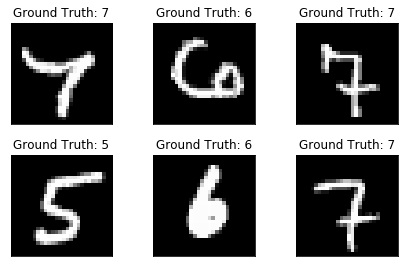

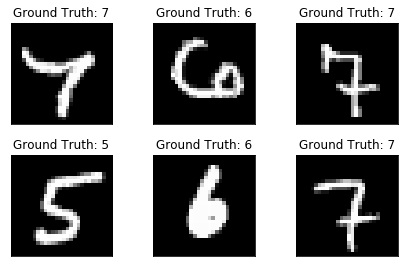

In [8]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title('Ground Truth: {}'.format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
fig

In [9]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1,10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(x,2)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.conv2_drop(x)
        x = F.max_pool2d(x,2)
        x = F.relu(x)
        x = x.view(-1,320)
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)
        
        

In [11]:
network = Net().to(device)
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [12]:
print(network)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [13]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [14]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                 epoch, batch_idx * len(data), len(train_loader.dataset),
                 100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
            (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), './output/model.pth')
            torch.save(optimizer.state_dict(), './output/optimizer.pth')

In [15]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)
        print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [16]:
test_loader.dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: /home/karan/Downloads/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

In [17]:
%%time
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()


Test set: Avg. loss: 2.3004, Accuracy: 751/10000 (8%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.331745
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.307435
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.289412
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.269871
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.246026
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.213428
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.109425
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.109599
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.923808
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.923711
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.786777
Train Epoch: 1 [14080/60000 (23%)]	Loss: 1.719109
Train Epoch: 1 [15360/60000 (26%)]	Loss: 1.589835
Train Epoch: 1 [16640/60000 (28%)]	Loss: 1.533771
Train Epoch: 1 [17920/60000 (30%)]	Loss: 1.433489
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.392532
Train Epoch: 1 [20480/60000 (34%)]	Loss: 1.336394
Train Epoch: 1 [21760/60000 (36%)]	Loss: 1.185301
Train Epoch: 1 [23040/60000 (38%)]	Loss: 1.257516
Train Epoc

**Evaluating the Model's Performance**

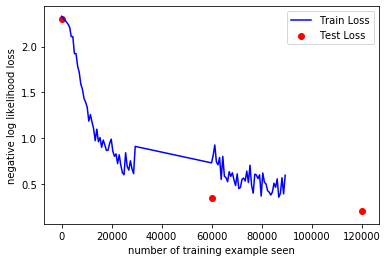

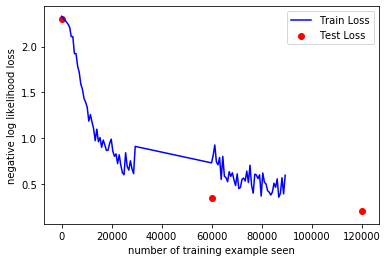

In [18]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training example seen')
plt.ylabel('negative log likelihood loss')
fig

In [20]:
with torch.no_grad():
    output = network(example_data.to(device))

/home/karan/.virtualenvs/kj/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


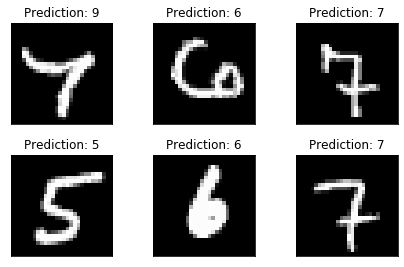

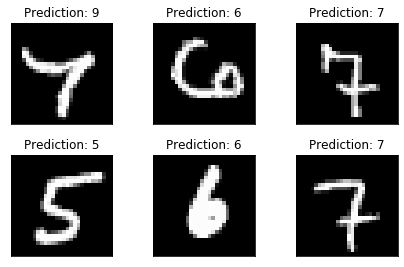

In [22]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title('Prediction: {}'.format(
    output.data.max(1, keepdim=True)[1][i].item()))
    
    plt.xticks([])
    plt.yticks([])
    
fig

**Continue training from checkpoints**

In [24]:
continued_network = Net()
continued_optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                               momentum=momentum)

In [25]:
network_state_dict = torch.load('./output/model.pth')
continued_network.load_state_dict(network_state_dict)

<All keys matched successfully>

In [26]:
optimizer_state_dict = torch.load('./output/optimizer.pth')
continued_optimizer.load_state_dict(optimizer_state_dict)

In [28]:
5*len(train_loader.dataset)

300000

In [31]:
for i in range(3,9):
    test_counter.append(i*len(train_loader.dataset))
    train(i)
    test()
    
    

/home/karan/.virtualenvs/kj/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 3 [0/60000 (0%)]	Loss: 0.252393
Train Epoch: 3 [1280/60000 (2%)]	Loss: 0.211800
Train Epoch: 3 [2560/60000 (4%)]	Loss: 0.351402
Train Epoch: 3 [3840/60000 (6%)]	Loss: 0.215965
Train Epoch: 3 [5120/60000 (9%)]	Loss: 0.295773
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.238147
Train Epoch: 3 [7680/60000 (13%)]	Loss: 0.234068
Train Epoch: 3 [8960/60000 (15%)]	Loss: 0.246795
Train Epoch: 3 [10240/60000 (17%)]	Loss: 0.142247
Train Epoch: 3 [11520/60000 (19%)]	Loss: 0.341399
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.377778
Train Epoch: 3 [14080/60000 (23%)]	Loss: 0.255945
Train Epoch: 3 [15360/60000 (26%)]	Loss: 0.188261
Train Epoch: 3 [16640/60000 (28%)]	Loss: 0.282368
Train Epoch: 3 [17920/60000 (30%)]	Loss: 0.340832
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.155059
Train Epoch: 3 [20480/60000 (34%)]	Loss: 0.271244
Train Epoch: 3 [21760/60000 (36%)]	Loss: 0.257063
Train Epoch: 3 [23040/60000 (38%)]	Loss: 0.195762
Train Epoch: 3 [24320/60000 (41%)]	Loss: 0.198253
Train Epoch: 3 [

/home/karan/.virtualenvs/kj/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0746, Accuracy: 9761/10000 (98%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.174849
Train Epoch: 4 [1280/60000 (2%)]	Loss: 0.261874
Train Epoch: 4 [2560/60000 (4%)]	Loss: 0.165239
Train Epoch: 4 [3840/60000 (6%)]	Loss: 0.289015
Train Epoch: 4 [5120/60000 (9%)]	Loss: 0.283202
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.290234
Train Epoch: 4 [7680/60000 (13%)]	Loss: 0.352926
Train Epoch: 4 [8960/60000 (15%)]	Loss: 0.215842
Train Epoch: 4 [10240/60000 (17%)]	Loss: 0.143285
Train Epoch: 4 [11520/60000 (19%)]	Loss: 0.227099
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.235144
Train Epoch: 4 [14080/60000 (23%)]	Loss: 0.238212
Train Epoch: 4 [15360/60000 (26%)]	Loss: 0.263507
Train Epoch: 4 [16640/60000 (28%)]	Loss: 0.212193
Train Epoch: 4 [17920/60000 (30%)]	Loss: 0.186694
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.285113
Train Epoch: 4 [20480/60000 (34%)]	Loss: 0.169623
Train Epoch: 4 [21760/60000 (36%)]	Loss: 0.164369
Train Epoch: 4 [23040/60000 (38%)]	Loss: 0.168650
Train Ep

Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.291466
Train Epoch: 7 [26880/60000 (45%)]	Loss: 0.177922
Train Epoch: 7 [28160/60000 (47%)]	Loss: 0.117028
Train Epoch: 7 [29440/60000 (49%)]	Loss: 0.094716
Train Epoch: 7 [30720/60000 (51%)]	Loss: 0.402710
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.125228
Train Epoch: 7 [33280/60000 (55%)]	Loss: 0.260881
Train Epoch: 7 [34560/60000 (58%)]	Loss: 0.212798
Train Epoch: 7 [35840/60000 (60%)]	Loss: 0.171072
Train Epoch: 7 [37120/60000 (62%)]	Loss: 0.153130
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.149090
Train Epoch: 7 [39680/60000 (66%)]	Loss: 0.102981
Train Epoch: 7 [40960/60000 (68%)]	Loss: 0.212090
Train Epoch: 7 [42240/60000 (70%)]	Loss: 0.121761
Train Epoch: 7 [43520/60000 (72%)]	Loss: 0.171766
Train Epoch: 7 [44800/60000 (75%)]	Loss: 0.212622
Train Epoch: 7 [46080/60000 (77%)]	Loss: 0.150425
Train Epoch: 7 [47360/60000 (79%)]	Loss: 0.119033
Train Epoch: 7 [48640/60000 (81%)]	Loss: 0.280985
Train Epoch: 7 [49920/60000 (83%)]	Loss: 0.219042


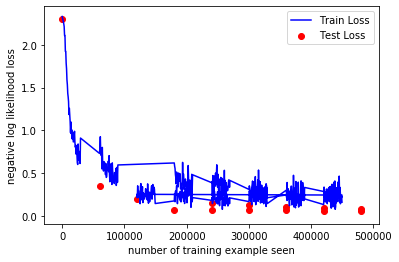

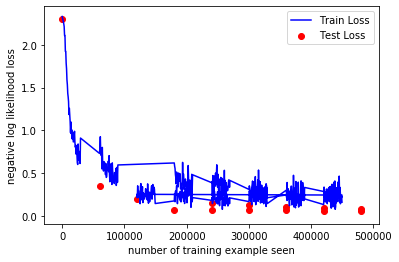

In [32]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training example seen')
plt.ylabel('negative log likelihood loss')
fig